In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import torch
import pandas as pd
from p2mpp.data.p2mpp_dataset import P2MPPDataset
from p2mpp.data.datamodule import DataModule
from tqdm.auto import tqdm

In [10]:
datamodule = DataModule(name="p2mpp",
                        data_list=r"test_problematic_files_v2.csv",
                        data_root=r"D:\ORamaVR\Datasets\P2MPP",
                        test_size=0.0,
                        seed=42,
                        batch_size=16,
                        num_workers=0,
                        num_points=9000
                        )


In [11]:
from p2mpp.models.p2m import P2MModel, BaseMeshConfig

In [12]:
basemeshconfig = BaseMeshConfig("ellipsoid", mesh_pose=(0.0, 0.0, 0.0))

In [13]:
model = P2MModel(
    hidden_dim=256,
    last_hidden_dim=128,
    coord_dim=3,
    backbone="vgg16",
    gconv_activation=True,
    z_threshold=0,
    align_with_tensorflow=True,
    camera_c=(112, 112),
    camera_f=(250.0, 250.0),
    base_mesh_config=basemeshconfig
)

c:\oramavr\python\pixel2meshplusplustorch\p2mpp\models\mesh\ellipsoid.py:21: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:607.)
  return torch.sparse.FloatTensor(i, v, shape)


In [14]:
ckpt = torch.load(r"C:\ORamaVR\Python\Pixel2MeshPlusPlusTorch\lightning_logs\version_5\checkpoints\epoch=756-step=66134.ckpt")

In [15]:
state_dict = {key.replace("model.", ""): value for key, value in ckpt["state_dict"].items() if "criterion." not in key}


In [16]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [22]:
import torch.nn.functional as F
model = model.cuda()
for i in tqdm(range(1000)):
    for batch in datamodule.train_dataloader():
        images = batch["images"]
        poses = batch["poses"]
        images = images.cuda()
        poses = poses.cuda()
        output = model(images, poses)
        F.binary_cross_entropy(output["reconst"], images)

  2%|▏         | 19/1000 [04:04<3:30:10, 12.86s/it]


KeyboardInterrupt: 

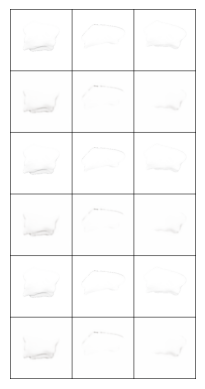

In [56]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# get the reconst tensor from the output dictionary
input_tensor = images.cpu()
reconst_tensor = output["reconst"].cpu()

t = torch.cat([input_tensor, reconst_tensor], dim=1)
batch_size, n_views, channel, height, width = t.shape
t = t.reshape(batch_size * n_views, channel, height, width)

# create a grid of images
grid_img = vutils.make_grid(t, nrow=3, normalize=True)

# display the grid
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()
